<a href="https://colab.research.google.com/github/gbwiersum/CLApartmentScraper/blob/main/CLScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install selenium -q
!apt install chromium-chromedriver -y -q
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import pandas as pd
import re

# Open a browser instance.
def start_browser():
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  browser = webdriver.Chrome('chromedriver', options=chrome_options)
  return(browser)

browser = start_browser()

Reading package lists...
Building dependency tree...
Reading state information...
chromium-chromedriver is already the newest version (100.0.4896.127-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [102]:
#Gets all listings for a given search query. If I had a main, this would be it.
#Pages come in batches of 120. Pass "-1" to pages for all.
def get_listings(start_url, pages=-1):
  results = {}
  if pages == -1:
    end = 2880
  else:
    end = pages*120

  for n in range(0, end, 120):
      if True: #hasnextpage():
        if n>0:
          browser.get((start_url+'?s='+str(n)))
        else:
          browser.get(start_url)

        #Debug: 
        pagestart = BeautifulSoup(browser.page_source).find('span', class_='rangeFrom').text
        pageend = BeautifulSoup(browser.page_source).find('span', class_='rangeTo').text
        print("Processing: "+pagestart+" through " + pageend)
        #####

        listings = browser.find_elements(by=By.CLASS_NAME, value='result-info')
        for l in listings:
          html = l.get_attribute('innerHTML')
          attributes = get_listing_attributes(html)
          results.update(attributes)
      else:
        break

  results = pd.DataFrame.from_dict(results, orient = 'index')
  return(results)

#Rewriting results page into dictionary format
#Takes html string of individual search result, returns dictionary with CL unique ID as index.
def get_listing_attributes(html):
    url = BeautifulSoup(html).a.get('href')

    #todo: I think something's broken here - always returns null?
    try:
      price = BeautifulSoup(html).find('span', class_="result-price").text
      price = int(price)
    except:
      price = None
    
    date = BeautifulSoup(html).find('time', class_="result-date").get('datetime')

    try:
      bed = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, after='Bd')
      bed = int(bed)
    except:
      bed=0

    try:
        sqft = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, before="", after="ft2")
        sqft = int(sqft)
    except:
        sqft=0

    heading = BeautifulSoup(html).find('a', class_="result-title hdrlnk").text
    id = BeautifulSoup(html).find('a', class_='result-title hdrlnk').get('data-id')

    return({id:[heading, url, price, date, bed, sqft]})


#utility to pull variables out of xml data using leading and following tag.
#I refusue to learn regex and this is my workaround for that.
def xml_getter(text, before="", after=""):
  m = re.search(before+'(.+?)'+after, text)
  if m:
      found = m.group(1).strip()
      return(found)


#TODO: This one I think is broken. Fix it.
#Utility to check for availability of next page.
#Returns true if page is available 
def hasnextpage():
  n=2
  while n<16:
    try:
      if BeautifulSoup(browser.page_source).find('a', class_='button next') != None:
        return(True)
      if BeautifulSoup(browser.page_source).find('a', class_='button next') == None & BeautifulSoup(browser.page_source).find('a', class_='button pagenum')!= None:
        return(False)
      elif BeautifulSoup(browser.page_source).find('a', class_='button pagenum')== None & n<8:
        time.sleep(n)
        n=n*2
        if n > 4:
          browser.refresh()
          time.sleep(10)
          return(BeautifulSoup(browser.page_source).find('a', class_='button next') != None)
        else:
          print("Nobody's supposed to see this dialog. Please contact project manager.")
          return(False)
    except Exception as ex:
      print(ex.args)
      print("Attempt to pull next page threw an exception. Please restart application")
      return(False)


#Gets attributes from specific listings. Returns a pandas series of attributes not listed in top-line search results
#TODO: add a progress bar
#TODO: run in batches, maybe a little more randomly so you don't get booted.
def get_listing_details(url):
  try:
    browser.get(url)
    pagesource = BeautifulSoup(browser.page_source)
    text = pagesource.find_all('p', class_='attrgroup')[1].text
    attrvals = []

    #Parking spaces, baths, description body, latitude and longitude
    park = re.search('\n(.+?)parking(.+?)\n', text)

    bedbath = BeautifulSoup(browser.page_source).find('span', class_='shared-line-bubble').text
    beds = xml_getter(bedbath, before='', after = "BR")
    baths = xml_getter(bedbath, before="/ ", after='Ba')

    body = BeautifulSoup(browser.page_source).find('section', id='postingbody').text

    try:  
      lat = BeautifulSoup(browser.page_source).find('div', id='map').get('data-latitude')
      lon = BeautifulSoup(browser.page_source).find('div', class_='viewposting leaflet-container leaflet-fade-anim leaflet-grab leaflet-touch-drag').get('data-longitude')
    except:
      lat=None
      lon=None

    attrvals.extend((baths, park, body, lat, lon))

    #Dogs/cats allowed, laundry situation:
    for attr in ['dog', 'cat', 'laundry']:
      try:
        spattr = re.search('\n'+attr+'(.+?)\n', text)
        attrvals.append(attr+spattr.group(1))
      except:
        attrvals.append(None)

    return(pd.Series(attrvals))

  except:
    print("An error was encountered. ")
    return(pd.Series(attrvals))

In [104]:
#listingdf = get_listings('https://chicago.craigslist.org/search/apa')
listingdf.columns = ['heading', 'url', 'rent', 'date posted', 'beds', 'sqft']
#Todo: get_listing_details will have to be run on subsets, not the entire dataset.
#Figure out how to run this without getting banned from craigslist for being too creepy.
atdf = listingdf['url'].apply(lambda x: get_listing_details(x))
atdf.columns=['baths', 'parking', 'body', 'lat', 'lon', 'dogs', 'cats', 'laundry' ]
df = listingdf.join(atdf)
df.to_csv('./CLScraped.csv')

IndexError: ignored

In [105]:
browser.page_source

'<html><head><title>blocked</title></head><body>Your request has been blocked.<br><br>If you have questions, please <a href="https://www.craigslist.org/contact?step=form&amp;reqKey=a9&amp;blockID=13027598">contact us</a>.</body></html>'

# Analysis

In [205]:
#df=pd.read_csv('./CLScraped.csv')
dummy = df[['rent','sqft', 'beds', 'baths', 'parking', 'lat', 'lon', 'dogs', 'cats', 'laundry']]
dummy['rent'] = dummy['rent'].apply(lambda x: (x-min(dummy['rent']))/(max(dummy['rent'])))
dummy['beds']=dummy['beds']/max(dummy['beds'])
dummy['dogs'].fillna(0, inplace=True)
dummy['dogs'].replace("dogs are OK - wooof", 1, inplace=True)
dummy['cats'].fillna(0, inplace=True)
dummy['cats'].replace('cats are OK - purrr', 1, inplace = True)
dummy['laundry'].replace('laundry in bldg', 1, inplace=True)
dummy["laundry"].replace('laundry on site', 1, inplace=True)
dummy['laundry'].fillna(0, inplace=True)
dummy[dummy['parking'].notnull()]['parking']=1
dummy['parking'].fillna(0, inplace=True)
dummy['sqft'].replace(0, None)

#########delete this later
def fixbaths(text):
  m = re.search('/ (.+?)', text)
  return(float(m.group(1)))
dummy['baths']=dummy['baths'].apply(lambda x: fixbaths(x))
#########

dummy['baths']=dummy['baths']/max(dummy['baths'])

dummy = dummy.drop(columns=['sqft', 'parking'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

In [206]:
dummy

,rent,beds,baths,lat,lon,dogs,cats,laundry
0,0.000000,0.00,0.5,42.000875,-87.662074,0,1,1.0
1,0.125000,0.00,0.5,41.930603,-87.640901,0,1,1.0
2,0.304688,0.00,0.5,41.743400,-87.980500,1,1,1.0
3,0.742188,1.00,1.0,41.928719,-87.646093,0,0,0.0
4,0.146875,0.25,0.5,41.913120,-87.702463,0,1,1.0
5,0.459375,0.25,0.5,41.893832,-87.641509,0,0,0.0
6,0.507812,0.75,0.5,41.798852,-87.596749,1,1,1.0
7,0.304688,0.00,0.5,41.743400,-87.980500,1,1,1.0
8,0.242188,0.50,1.0,41.848532,-87.678153,1,1,0.0
9,0.359375,0.50,0.5,41.971900,-87.662400,0,1,0.0


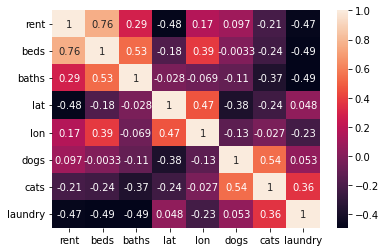

In [207]:
import seaborn as sns
sns.heatmap(dummy.corr(), annot=True)

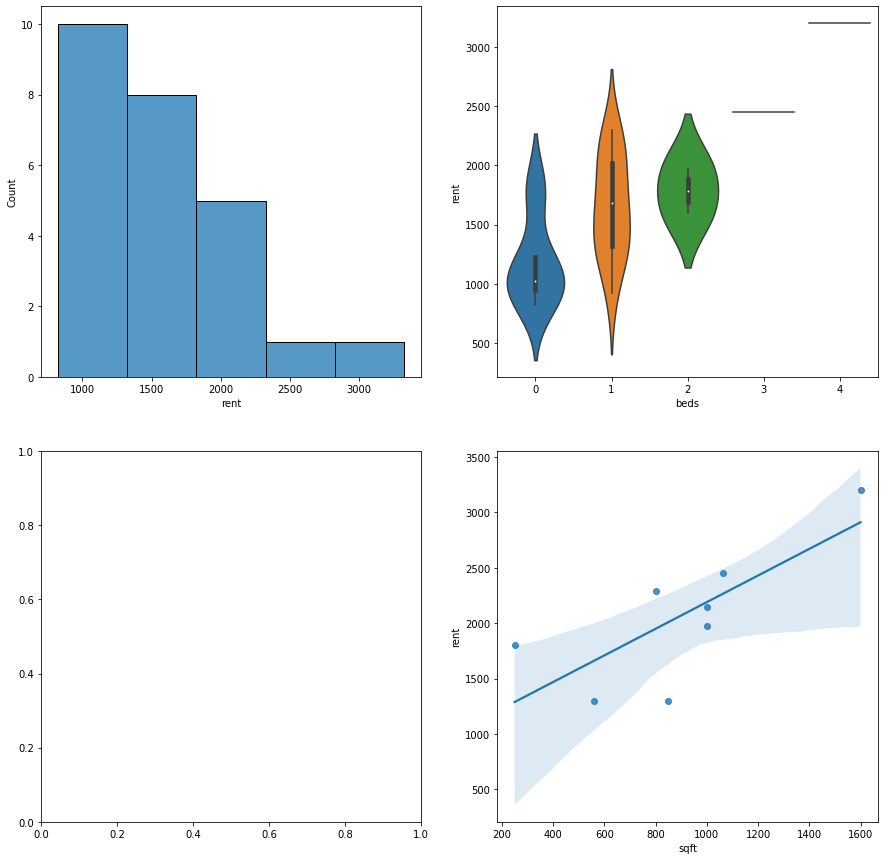

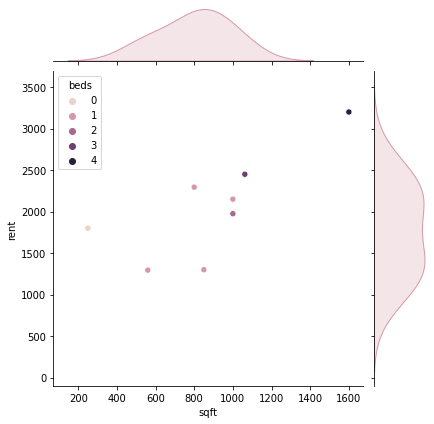

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt
 
fig, axes = plt.subplots(2,2 , figsize=(15, 15))
sns.histplot(ax=axes[0,0], data=df['rent'], binwidth=500)
sns.violinplot(ax=axes[0,1], x=df["beds"], y=df["rent"])
sns.jointplot(ax=axes[1,0], x=df[df['sqft']>0]['sqft'], y=df[df['sqft']>0]['rent'], hue=df['beds'])
sns.regplot(ax=axes[1,1], x=df[df['sqft']>0]['sqft'], y=df[df['sqft']>0]['rent'])

In [209]:
from scipy.stats import linregress
slope, intercept, r, p, se = linregress(x=df[df['sqft']>0]['sqft'], y=df[df['sqft']>0]['rent'])
print(slope*2100+intercept)

3511.8673264992976


In [ ]:

#For scraping historical data:

for i in links:
	soup = BeautifulSoup(requests.get(i).content, 'html.parser')
	date_plus = str(soup).split("web/",1)[1].split("/http",1)[0]
	historic_scrape(0,soup,date_plus)
	print("***** Link" + str(i) + "completed *****")

def get_links(years=["2020", "2021", "2022"]):

  # List the years you'll loop over
  years = ["2020", "2021", "2022"]
  # And instantiate a list we'll put links in
  linklist = []

  for y in years:
    try:
      calpage = "https://web.archive.org/web/" + str(y) + "0101000000*/http://www.chicago.craigslist.org/search/apa"
      browser.get(calpage)  # doing this twice ensures that it loads correctly
      browser.get(calpage)
      time.sleep(1)
      try:
        cal = browser.find_elements(by=By.CLASS_NAME, value='calendar-day')
      except:
        time.sleep(3) # sometimes the browser loads slowly--just try again
        cal = browser.find_elements(by=By.CLASS_NAME, value='calendar-day')
      for c in cal:
        html = c.get_attribute("innerHTML") # get the calendar's html content
        soup = BeautifulSoup(html, 'html.parser') # turn it into a soup
        link = str(soup.a) # the name of the chunk containing links
        url = "https://web.archive.org" + link.split('"', 1)[1].split('"',1)[0]
        if url not in linklist: # if we don't already have it, add it to the list
          linklist.append(url)
    except:  # if a page does not exist, continue to the next one
      continue
  return(linklist)

links = get_links()
links.append("https://chicago.craigslist.org/search/apa") #Add current day's listings

start_url = 'https://chicago.craigslist.org/search/apa'
pages = -1

results = {}
if pages == -1:
  end = 2880
else:
  end = pages*120

for n in range(0, end, 120):
    if True: #hasnextpage():
      if n>0:
        browser.get((start_url+'?s='+str(n)))
      else:
        browser.get(start_url)

      #Debug: 
      pagestart = BeautifulSoup(browser.page_source).find('span', class_='rangeFrom').text
      pageend = BeautifulSoup(browser.page_source).find('span', class_='rangeTo').text
      print("Processing: "+pagestart+" through " + pageend)
      #####

      listings = browser.find_elements(by=By.CLASS_NAME, value='result-info')
      for l in listings:
        html = l.get_attribute('innerHTML')
        attributes = get_listing_attributes(html)
        results.update(attributes)
    else:
      break

len(listings)
pd.DataFrame(results)